In [1]:
import os
import matplotlib.pyplot as plt


In [2]:
import os
import json
import pandas as pd
import tqdm

# read file
data_dir = "../../external_projects/bva-citation-prediction/data/preprocessed-cached/preprocessed-cached-v4-mini/"
# get list of filepaths in data_dir
filepaths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

dfs = [] # an empty list to store the data frames
for file in tqdm.tqdm(filepaths):
    data = pd.read_json(file, lines=True) # read data frame from json file
    dfs.append(data) # append the data frame to the list

df = pd.concat(dfs, ignore_index=True)
df.head()


100%|██████████| 1000/1000 [00:04<00:00, 210.23it/s]


,bva_id,txt,citation_texts,citation_vocab,citation_indices
0,503881,citation nr 0503881 decision date 02 14 05 arc...,"[38 C.F.R. § 4.125(a), 38 C.F.R. § 3.304(f), 3...","[[38 C.F.R. §, 38 C.F.R. 4.125, 38 C.F.R.], [3...","[[430], [173], [1072], [651], [374], [791], [3..."
1,1546378,citation nr 1546378 decision date 11 02 15 arc...,"[Reonal v. Brown, 5 Vet. App. 458, 461 (1993),...","[[Reonal_5 Vet. App. 458], [38 C.F.R. §, 38 C....","[[579], [54], [273], [3], [4, 5]]"
2,1141205,citation nr 1141205 decision date 11 04 11 arc...,"[38 U.S.C.A. §§ 1101, 1110, 1112, 1131, 5107, ...","[[38 U.S.C.A. §§, 38 U.S.C.A. 1101, 38 U.S.C.A...","[[44, 45, 46, 55, 21], [49, 152, 153, 50, 51, ..."
3,23539,citation nr 0023539 decision date 09 05 00 arc...,"[38 U.S.C.A. § 7105(a)-(c), 38 C.F.R. §§ 3.104...","[[38 U.S.C.A. §, 38 U.S.C.A. 7105, 38 U.S.C.A....","[[1], [197, 812], [102], [103], [106], [3452],..."
4,1042611,citation nr 1042611 decision date 11 12 10 arc...,"[38 C.F.R. § 3.385, 38 U.S.C.A. §§ 1101, 1110,...","[[38 C.F.R. §, 38 C.F.R. 3.385], [38 U.S.C.A. ...","[[469], [44, 45, 46, 47, 18, 19], [22, 12, 49,..."


In [73]:
# return all occurences of str in string
def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches

df['num_citations'] = df['citation_vocab'].apply(lambda x: len(x))

## stats on number of citations

In [74]:
figures = [] # add all plotly figures here

In [90]:
import plotly.express as px
fig = px.histogram(df, x="num_citations", nbins=50)
# title
fig.update_layout(title_text="Number of citations per paper")
fig.show()
figures.append(fig)

In [76]:
# percentiles
percentiles = [i/10 for i in range(0, 10)]
citations_per_percentile = df['num_citations'].quantile(percentiles)
# create the same scatter plot in plotly
fig = px.scatter(x=percentiles, y=citations_per_percentile, labels={"x": "percentile", "y": "avg Number of citations"})
title = "percentiles of citations per document"
fig.update_layout(title_text=title)
fig.update_xaxes(title_text="percentile")
fig.update_yaxes(title_text="avg Number of citations")
fig.show()
figures.append(fig)


In [77]:
# percentages of documents with more than x citations
thresholds = [i*5 for i in range(20)]
occurences = []
for threshold in thresholds:
    # count occurences of num_citations above threshold
    occurences.append(df["num_citations"][df['num_citations'] > threshold].count())
# normalize by total number of documents
occurences = [i/len(df) for i in occurences]

# redo the same plot in plotly
fig = px.scatter(x=thresholds, y=occurences, labels={"x": "threshold num citations", "y": "fraction of documents"})
title = "number of documents with citations above threshold"
fig.update_layout(title_text=title)
fig.update_xaxes(title_text="threshold num citations")
fig.update_yaxes(title_text="fraction of documents")

# add the lines to the plot
fig.show()
figures.append(fig)


In [78]:
# average number of citations per document
print("average number of citations per document:", df['num_citations'].mean())
# total number of citations
print("total number of citations:", df['num_citations'].sum())
print("num docuemnts", len(df))

average number of citations per document: 21.425
total number of citations: 21425
num docuemnts 1000


## types of citations

In [79]:
is_statute = lambda citation_variants: any("§" in variant for variant in citation_variants)
count_statutes = lambda citations: sum(is_statute(citation) for citation in citations)
count_cases = lambda citations: sum(not is_statute(citation) for citation in citations)

df['num_statues'] = df['citation_vocab'].apply(count_statutes)
df['count_cases'] = df['citation_vocab'].apply(count_cases)
# df['num_statues'].hist(bins=20, alpha=0.5, label='statutes')
# df['count_cases'].hist(bins=20, alpha=0.5, label='cases')

# draw the same plot in plotly
fig = px.histogram(df, x="num_statues", nbins=50)
fig = px.histogram(df, x="count_cases", nbins=50)

# use go.histogramm to draw the histogram
import plotly.graph_objects as go
fig = go.Figure(data=[go.Histogram(x=df['num_statues'], nbinsx=50, name='statutes'),
                      go.Histogram(x=df['count_cases'], nbinsx=50, name='cases')])

# add title
fig.update_layout(title_text="number of statutes and cases per document")
fig.show()
figures.append(fig)


## most common citations

In [80]:
# to simplify: use only longest string of citation variants
def get_longest(citations):
    longest_variants = []
    for citation_variants in citations:
        longest = max(citation_variants, key=len)
        longest_variants.append(longest)
    return longest_variants

df['longest_citations'] = df['citation_vocab'].apply(get_longest)
# longest citations is a list of citations instead of a list of a list of citations

In [81]:
from collections import Counter
# count duplicates in df['longest_citations']
all_citations = df['longest_citations'].to_list()
# flatten all_citations
def flatten(t):
    return [item for sublist in t for item in sublist]

flattened = flatten(all_citations)
counted = Counter(flattened)


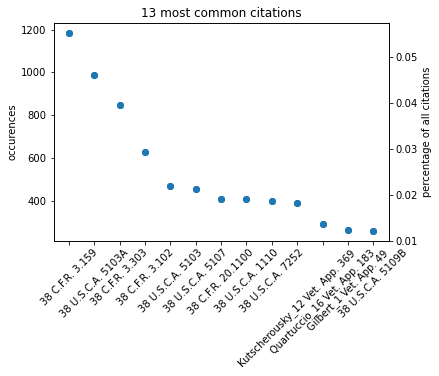

In [82]:
# select the 13 most common items
n = 13
most_common = counted.most_common(n)
# convert list of tuples to two lists
most_common_citations, most_common_counts = zip(*most_common)
# normalize most_common_counts by total number of citations
# make the x axis labels diagonal
plt.xticks(rotation=45)

plt.scatter(most_common_citations, most_common_counts)
# show second y axis
plt.ylabel("occurences")

# show second y axis for normalized values
plt.twinx()
most_common_counts_normalized = [(i/len(flattened)) for i in most_common_counts]
plt.scatter(most_common_citations, most_common_counts_normalized)
plt.ylabel("percentage of all citations")

plt.title(str(n) + ' most common citations')
plt.show()

from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=most_common_citations, y=most_common_counts, name="occurences"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=most_common_citations, y=most_common_counts_normalized, name="percentage of all citations", ),
    secondary_y=True,
)

title = "most common citations"
fig.update_layout(title_text=title)
fig.update_xaxes(title_text="citation")

fig.update_yaxes(title_text="percentage of all citations", secondary_y=True)
figures.append(fig)
fig.show()


In [83]:
# mean of occurence count values
print(sum(list(counted.values()))/len(list(counted.values())))

13.441028858218319


In [84]:
# number of unique citations
print(len(list(counted.keys())))

1594


In [85]:
# show some least common occurances
least_common = counted.most_common()[-10:]
print("citation, occurences")
for el in least_common:
    print(el)

citation, occurences
('38 C.F.R. 317', 1)
('38 C.F.R. 4.110', 1)
('Ruker_10 Vet. App. 67', 1)
('May_19 Vet. App. 310', 1)
('Russell_3 Vet. App. 313', 1)
('10 Vet. App. 153', 1)
('7 Vet. App. 511', 1)
('Willis_1 Vet. App. 66', 1)
('Caranto_4 Vet. App. 516', 1)
('Wagner_370 F. 3', 1)


## Document texts
### average number of words

In [86]:
count_words = lambda x: len(x.split(" "))
df['num_words'] = df['txt'].apply(count_words)

# plot num_word percentiles
bins = 10
percentiles = [i/bins for i in range(0, bins)]
num_words_per_percentile = df['num_words'].quantile(percentiles)

# make the same scatter plot in plotly
fig = px.scatter(x=percentiles, y=num_words_per_percentile, labels={"x": "percentile", "y": "avg number of words"})
fig.update_layout(title_text="percentiles of number of words per document")
figures.append(fig)
fig.show()


In [87]:
# average number of words
print(df['num_words'].mean())

2306.677


### citations per sentence: 
with an avg of ~20 citations and 2300 words per doc, and assuming 15 words per sentence there is a citation every ~7 sentences

### citation positions 
(relative to document length)
only for documents between length 800 and 1000

In [88]:
def normalize_nested_indices(x, txt):
    length = len(txt)
    tmp = find_all(txt, "@cit@")
    # find all indices of substring str in txt
    tmp = [el /length for el in tmp]
    return tmp

# drop docuements with num_words > 1000
df_short = df[df['num_words'] < 1500]
df_short = df_short[df_short['num_words'] > 1200]

df_short['normalized_indices'] = df_short.apply(lambda x: normalize_nested_indices(x['citation_indices'], x['txt']), axis=1)

flattened = flatten(df_short['normalized_indices'].to_list())

# draw same plot in plotly
fig = px.histogram(x=flattened, nbins=20)
fig.update_layout(title_text="Histogramm of normalized indices of citations per document")
fig.update_yaxes(title_text="Number of occurrences")
fig.update_xaxes(title_text="Normalized indices")
fig.show()

figures.append(fig)


In [89]:
with open('preprocessed_stats.html', 'a') as f:
    for fig in figures:
        f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
